In [1]:
from UTIL import FileIO
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import statsmodels
import ffn
from itertools import product

from STRATEGY.Kalman import Kalman

from statsmodels.regression.rolling import RollingOLS

import warnings
warnings.filterwarnings('ignore')
import sys

/Users/Ferni/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
import importlib
importlib.reload(sys.modules['STRATEGY.Kalman'])
from STRATEGY.Benchmark import Benchmark

In [3]:

# Read config
config_path  = 'CONFIG/config_train.yml'
config_train = FileIO.read_yaml(config_path) 

verbose = False

In [4]:

# Read prices
x = pd.read_csv('STATICS/PRICE/ul.csv')
y = pd.read_csv('STATICS/PRICE/ulvr.csv')
print('Observations in source | RYA : {rya} , RYAAY : {ryaay} '.format(rya = len(x), ryaay = len(y)))

a, b = Kalman.clean_data(x, y, 'date', 'close', False)
print('After merging on date  | RYA : {rya} , RYAAY : {ryaay} '.format(rya = len(a), ryaay = len(b)))

a, b = Kalman.clean_data(x, y, 'date', 'close', True)
print('After removing outliers| RYA : {rya} , RYAAY : {ryaay} '.format(rya = len(a), ryaay = len(b)))

Observations in source | RYA : 134550 , RYAAY : 157682 
After merging on date  | RYA : 31631 , RYAAY : 31631 
After removing outliers| RYA : 31108 , RYAAY : 31108 


In [5]:
#kalman_keep_outliers = Kalman(x,y,'date', 'close',  is_cleaned = False, rm_outliers = False)
kalman_rm_outliers   = Kalman(x,y,'date', 'close',  is_cleaned = False, rm_outliers = True)

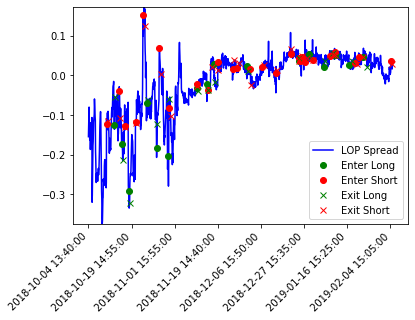

-0.26 percent return in time window
Stats for cum rets from 2018-10-04 13:40:00 - 2020-04-03 14:55:00
Annual risk-free rate considered: 0.16%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
1.35%               0.79  0.90%   -0.79%

Annualized Returns:
mtd    3m     6m     ytd    1y     3y     5y    10y    incep.
-----  -----  -----  -----  -----  -----  ----  -----  --------
0.00%  0.16%  0.18%  0.14%  1.68%  0.90%  -     -      0.90%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  0.79     1.03       0.69
mean    0.93%    0.87%      0.74%
vol     0.97%    0.69%      0.84%
skew    6.16     0.39       -
kurt    53.59    -1.50      -
best    0.60%    0.39%      1.34%
worst   -0.18%   -0.19%     0.14%

Drawdowns:
max     avg       # days
------  ------  --------
-0.79%  -0.18%        35

Misc:
---------------  -------
avg. up month    0.24%
avg. down month  -0.09%
up year %        100.00%
1

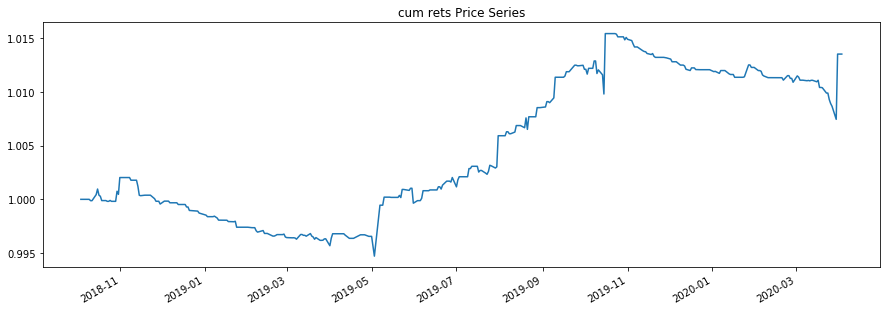

In [23]:
# Test out settings
settings = {'entryZ': 2, 'exitZ': 0, 'lag': 1, 'resample': 5, 'rounding': 3, 'minHalflife': 50}

kalman_rm_outliers.process(transaction_cost=0.0063, **settings)
trade_record = kalman_rm_outliers.record
kalman_rm_outliers.plot_signals(trade_record,"2018-02-01","2019-02-04",1)

perf = ffn.PerformanceStats(trade_record['cum rets'], rf = 0.0016)
perf.display()
perf.plot()

In [11]:
# Calculate the benchmark performance for a given range of parameter values
def calculate_benchmark(default, v1_name, v1_values, v2_name = None, v2_values = None):
    
    #Copy dictionary
    param_dict = {}
    for key in default:
        param_dict[key] = [default[key]]
    
    #Set the parameter ranges
    param_dict[v1_name] = v1_values
    if(v2_values is not None):
        param_dict[v2_name] = v2_values
    
    #Create output dataframe
    cols = list(param_dict.keys())
    cols.extend(['perf'])
    benchmark_output = pd.DataFrame(columns = cols)
    
    #Process for the value combinations
    for p in tqdm(list(product(*param_dict.values()))):
        bench = kalman_keep_outliers if p[5] else kalman_rm_outliers
        a = {}
        for i,key in enumerate(default.keys()):
            a[key] = p[i]
        
        bench.process(transaction_cost=0.0063, **a)
        trade_record = bench.record
        a['outliers'] = p[len(default)-1]
        a['perf'] = ffn.PerformanceStats(trade_record['cum rets'], rf = 0.0016)
        #a['halflife'] = bench.halflife
        benchmark_output = benchmark_output.append(a, ignore_index=True)
        
    return benchmark_output

def trisurf_plot(x,y,z,v1,v2,stat):
    fig = plt.figure()
    
    ax = fig.gca(projection='3d')
    
    surf = ax.plot_trisurf(x, y, z, cmap=cm.jet, linewidth=0, \
                           antialiased=True, label=stat+' statistic for ' + v1 + ' vs ' + v2)
    fig.colorbar(surf)
    
    ax.set_xlabel(v1, fontsize=15)
    ax.set_ylabel(v2, fontsize=15)
    ax.set_zlabel(stat, fontsize=15)

    
    fig.tight_layout()
    plt.show()
    
# Plot a statistic like the sharpe ratio of the benchmark for a given range of parameter values
def plot_sharpe(default_dict, v1_name, v1_values, v2_name = None, v2_values = None, \
                stat = 'daily_sharpe', maximize = True):

    is_3d = v2_name is not None
    
    out_df = calculate_benchmark(default_dict, v1_name, v1_values, v2_name, v2_values)
    
    n =  len(v1_values) *  len(v2_values)
    x = np.ones(n)
    y = np.ones(n)
    z = np.ones(n)
    count = 0
    
    for i in v1_values:
        for j in v2_values:
            default_dict[v1_name] = i
            default_dict[v2_name] = j
            
            x[count] = i
            y[count] = j
            perf = out_df.loc[(out_df[list(default_dict)] == pd.Series(default_dict)).all(axis=1)]['perf'].iloc[0]
            z[count] = perf.stats[stat]
            
            count = count + 1
    print(x)
    print(y)
    print(z)
    trisurf_plot(x,y,z,v1_name,v2_name,stat)
    
    maxIdx = z.argmax() if maximize else z.argmin()
    print('Best ' + stat + ' reached at {s}'.format(s = round(z[maxIdx],3))+ \
          ' for ' + v1_name + ' and ' + v2_name + \
          ' equal to {a} and {b}'.format(a = round(x[maxIdx],2), b = round(y[maxIdx],2)))

100%|██████████| 4/4 [00:01<00:00,  3.90it/s]

[1. 1. 1. 1.]
[0. 1. 2. 3.]
[1.70568797 0.85969096 0.91449024 0.13827311]


RuntimeError: Error in qhull Delaunay triangulation calculation: input inconsistency (exitcode=1); use python verbose option (-v) to see original qhull error.

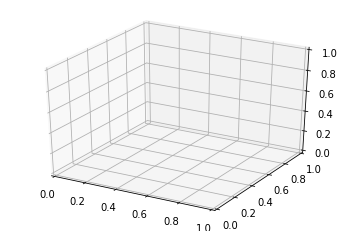

In [13]:
# Let's see the lag vs resample sharpes
default = {'entryZ': 2, 'exitZ': 0, 'lag': 1, 'resample': 2, 'rounding': 3, 'outliers' : False}
plot_sharpe(default, 'resample', [1,2,3,5,10],'lag', [0,1,2,3])#, stat = 'total_return', maximize = True)

In [ ]:
# Clearly, the larger lags values eliminate the power of the model
# Don't allow 0 lag
default = {'entryZ': 2, 'exitZ': 0, 'lag': 1, 'resample': 2, 'rounding': 3, 'outliers' : False}
plot_sharpe(default, 'resample', [1,2,3,5,10],'lag', [1,2])#, stat = 'total_return', maximize = True)

100%|██████████| 20/20 [01:50<00:00,  5.55s/it]


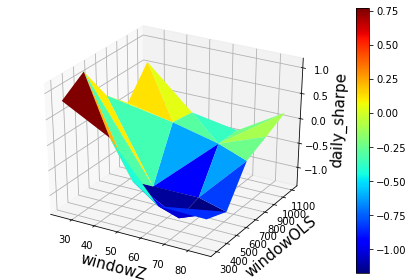

Best daily_sharpe reached at 1.134 for windowZ and windowOLS equal to 25.0 and 500.0


In [16]:
# Look for optimal window sizes
default = {'entryZ': 2, 'exitZ': 0, 'lag': 2, 'resample': 10, 'rounding': 3,'outliers' : False}
plot_sharpe(default,'windowZ', list(np.arange(25, 100, 20)), 'windowOLS', list(np.arange(300, 1300, 200)))

In [18]:
# Adjust the OLS window
bench_keep_outliers = Benchmark(x,y,'date', 'close', windowOLS = 500, is_cleaned = False, rm_outliers = False)
bench_rm_outliers   = Benchmark(x,y,'date', 'close', windowOLS = 500, is_cleaned = False, rm_outliers = True)

100%|██████████| 50/50 [00:05<00:00,  9.47it/s]


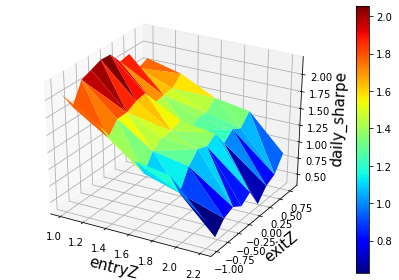

Best daily_sharpe reached at 2.217 for entryZ and exitZ equal to 1.0 and -0.2


In [19]:
# Best entry vs exit Z
default = {'entryZ': 2, 'exitZ': 0, 'lag': 1, 'resample': 10, 'rounding': 3, 'windowZ':25,'outliers' : False}
plot_sharpe(default,'entryZ', list(np.arange(1, 2.5, 0.3)), 'exitZ', list(np.arange(-1, 1, 0.2)))

100%|██████████| 10/10 [00:01<00:00,  6.96it/s]


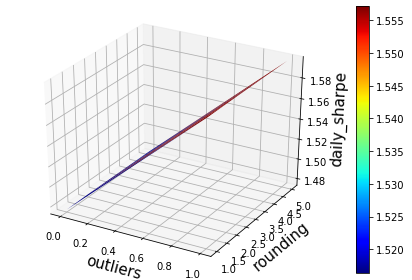

Best daily_sharpe reached at 1.598 for outliers and rounding equal to 1.0 and 3.0


In [21]:
# Rounding and outliers?
default = {'entryZ': 1, 'exitZ': 0, 'lag': 1, 'resample': 10, 'rounding':2 , 'outliers' : False}
plot_sharpe(default, 'outliers', [True, False],'rounding', [1,2,3,4,5])

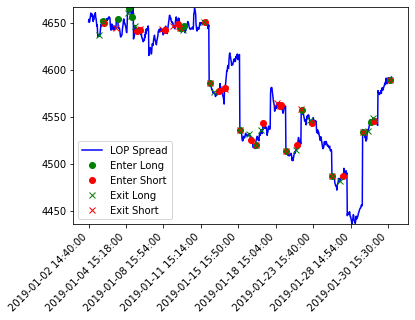

0.39 percent return in time window
Stats for cum rets from 2018-10-05 14:44:00 - 2020-03-27 15:56:00
Annual risk-free rate considered: 0.16%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
3.17%               0.58  2.14%   -3.67%

Annualized Returns:
mtd    3m     6m      ytd    1y     3y     5y    10y    incep.
-----  -----  ------  -----  -----  -----  ----  -----  --------
1.22%  0.45%  -1.77%  0.38%  0.72%  2.14%  -     -      2.14%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  0.58     0.74       0.89
mean    2.25%    2.30%      1.21%
vol     3.61%    2.89%      1.17%
skew    0.10     -1.33      -
kurt    4.94     3.70       -
best    1.18%    1.29%      2.03%
worst   -1.23%   -2.24%     0.38%

Drawdowns:
max     avg       # days
------  ------  --------
-3.67%  -0.59%     20.65

Misc:
---------------  -------
avg. up month    0.57%
avg. down month  -0.71%
up year %        100.00%

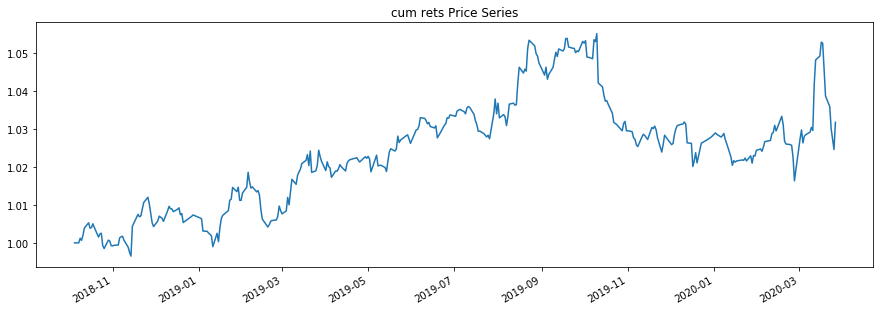

In [24]:
# Benchmark number one: lagged variable with low resampling with optimized parameters
kalman_lagged  = Benchmark(x,y,'date', 'close', is_cleaned = False, rm_outliers = True)

# Lower entry requirement and relatively short OLS and z windows
settings = {'entryZ': 1, 'exitZ': 0, 'lag': 1, 'resample': 2, 'rounding': 3}

fromDate = "2019-01-01"
toDate =    "2019-01-30"
kalman_lagged.process(transaction_cost=0.0063, **settings)
trade_record = kalman_lagged.record
kalman_lagged.plot_signals(trade_record,fromDate,toDate,1)

perf = ffn.PerformanceStats(trade_record['cum rets'], rf = 0.0016)
perf.display()
perf.plot()

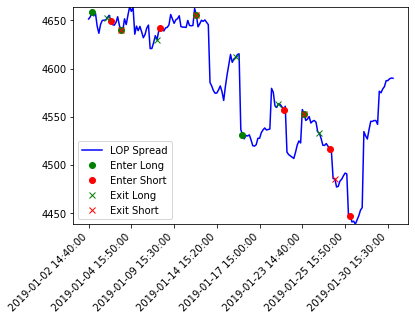

0.41 percent return in time window
Stats for cum rets from 2018-10-12 14:00:00 - 2020-03-27 16:00:00
Annual risk-free rate considered: 0.16%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
10.69%              2.03  7.22%   -2.19%

Annualized Returns:
mtd    3m     6m     ytd    1y     3y     5y    10y    incep.
-----  -----  -----  -----  -----  -----  ----  -----  --------
1.50%  0.26%  1.92%  0.23%  6.49%  7.22%  -     -      7.22%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  2.03     2.35       0.72
mean    7.25%    6.90%      4.63%
vol     3.49%    2.87%      6.22%
skew    -0.51    -0.33      -
kurt    4.65     -1.24      -
best    0.95%    1.63%      9.02%
worst   -1.23%   -0.71%     0.23%

Drawdowns:
max     avg       # days
------  ------  --------
-2.19%  -0.36%         9

Misc:
---------------  -------
avg. up month    0.94%
avg. down month  -0.63%
up year %        100.00%
12

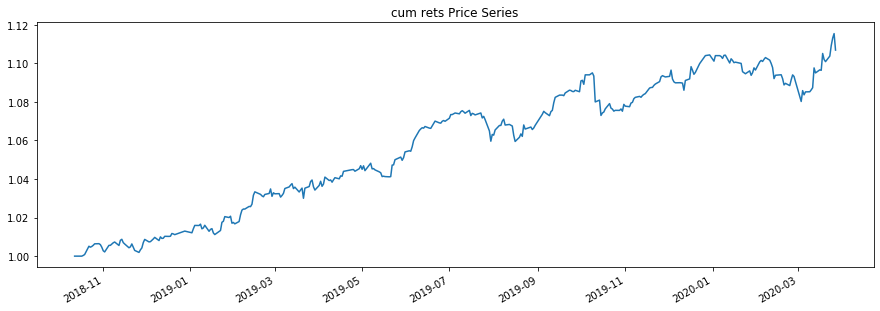

In [26]:
# Benchmark number two: no lag but less frequent observations with 5minute resampling. 

bench_resampled   = Benchmark(x,y,'date', 'close', windowOLS = 500, is_cleaned = False, rm_outliers = True)

# Higher entry requirement because will hold longer. Higher z and OLS windows
settings = {'entryZ': 1, 'exitZ': 0, 'lag': 1, 'resample': 10, 'rounding': 3,'windowZ' : 25}

fromDate = "2019-01-01"
toDate =    "2019-01-30"
bench_resampled.process(transaction_cost=0.0063, **settings)
trade_record = bench_resampled.record
bench_resampled.plot_signals(trade_record,fromDate,toDate,1)

perf = ffn.PerformanceStats(trade_record['cum rets'], rf = 0.0016)
perf.display()
perf.plot()

In [22]:
trade_record.to_csv('exampleKalman.csv')